# Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

print(tf.__version__)

2.17.0


# data modeling

In [2]:
import os
from PIL import Image

images = []
ages = []
genders = []

for i in os.listdir('crop_part1')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open(os.path.join('crop_part1', i)))

In [3]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df

,Images,Ages,Genders
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100,1
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,101,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10,0
...,...,...,...
7995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1
7996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1
7997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1
7998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1


## Populating list of Age and Gender from the dataset

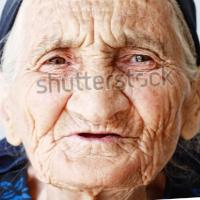

100 1


In [4]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0])

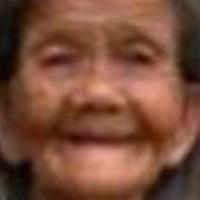

100 1


In [5]:
display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1])

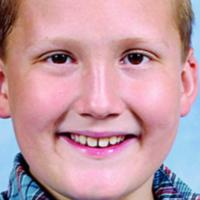

10 0


In [6]:
display(df['Images'][4])
print(df['Ages'][4], df['Genders'][4])

## Visualising and Preparing Data

<Axes: xlabel='Ages', ylabel='Density'>

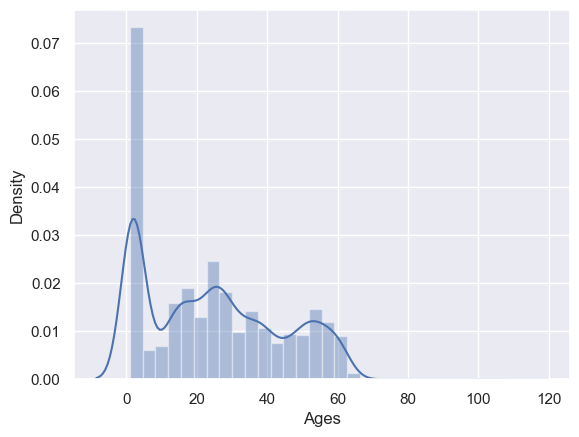

In [7]:
import warnings

warnings.filterwarnings('ignore')

sns.set_theme()
sns.distplot(df['Ages'],kde=True, bins=30)

In [8]:
under4s = df[df['Ages'] <= 4].sample(frac=0.3)

# Keep only rows where 'Ages' > 4
df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index=True)

<Axes: xlabel='Ages', ylabel='Density'>

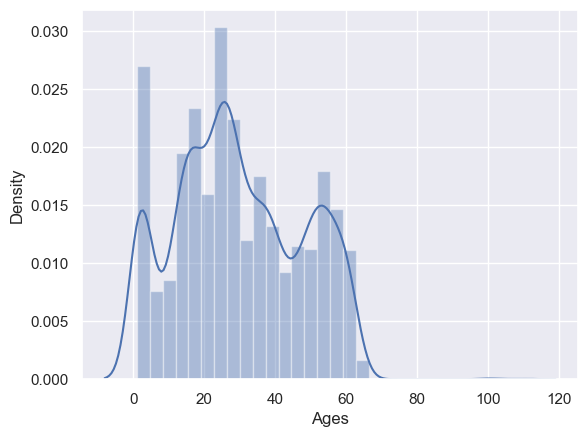

In [9]:
sns.distplot(df['Ages'],kde=True, bins=30)

In [10]:
import matplotlib.pyplot as plt

print(df['Genders'].unique())

[1 0 3]


In [11]:
df = df.dropna(subset=['Genders'])

In [12]:
valid_genders = [0, 1]  # Assuming these are the valid values
df = df[df['Genders'].isin(valid_genders)]

In [14]:
df['Genders'].value_counts()

Genders
1    3632
0    2875
Name: count, dtype: int64

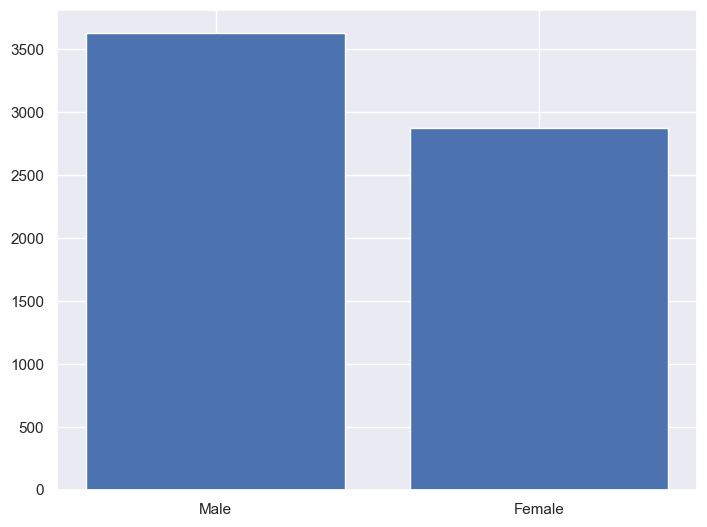

In [15]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
gender = ["Male", "Female"]
values = df['Genders'].value_counts()
ax.bar(gender, values)
plt.show()

In [16]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.Resampling.LANCZOS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)
x = np.array(x)

## Train Test Split

In [17]:
df['Ages'].value_counts()
df['Genders'].value_counts()

Genders
1    3632
0    2875
Name: count, dtype: int64

In [18]:
df = df[df['Ages'].map(df['Ages'].value_counts()) > 1]
df = df[df['Genders'].map(df['Genders'].value_counts()) > 1]

#### Remove Classes with Only 1 Sample
If any class has only one sample, you can remove them or handle them separately:

In [19]:
y_age = df['Ages']
y_gender = df['Genders']

# Remove classes with less than 2 samples in 'Ages'
age_counts = y_age.value_counts()
valid_age_classes = age_counts[age_counts >= 2].index
df = df[df['Ages'].isin(valid_age_classes)]

# Remove classes with less than 2 samples in 'Genders'
gender_counts = y_gender.value_counts()
valid_gender_classes = gender_counts[gender_counts >= 2].index
df = df[df['Genders'].isin(valid_gender_classes)]

# Update x, y_age, y_gender after filtering
x = np.array([np.asarray(img) for img in df['Images']])
y_age = df['Ages']
y_gender = df['Genders']

After cleaning the dataset, you can rerun the train_test_split:

In [20]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

## Creating the Models

In [21]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

# Corrected optimizer argument
agemodel.compile(loss='mean_squared_error',
                 optimizer=optimizers.Adam(learning_rate=0.0001))

genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

# Corrected optimizer argument
genmodel.compile(loss='binary_crossentropy',
                 optimizer=optimizers.Adam(learning_rate=0.0001),
                 metrics=['accuracy'])


## Training the Models

In [22]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test1 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=128)

history1 = agemodel.fit(train1, epochs=30, shuffle=True, validation_data=test1)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - loss: 563.8950 - val_loss: 309.9159
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - loss: 355.9784 - val_loss: 290.6279
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - loss: 330.0359 - val_loss: 259.4740
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - loss: 298.5610 - val_loss: 235.8989
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - loss: 264.7681 - val_loss: 224.3896
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - loss: 270.0918 - val_loss: 226.0688
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - loss: 263.6270 - val_loss: 258.3687
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - loss: 265.0326 - val_loss: 222.8927
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - loss: 252.6149 - val_loss: 201.0945
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - loss: 242.1441 - val_loss: 198.3216
Epoch 11/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - loss: 241.6808 - val_loss: 202.27

In [23]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=128)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=128)

history2 = genmodel.fit(train2, epochs=30, shuffle=True, validation_data=test2)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 667s 13s/step - accuracy: 0.5759 - loss: 0.6718 - val_accuracy: 0.6928 - val_loss: 0.5796
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 610s 15s/step - accuracy: 0.6795 - loss: 0.6007 - val_accuracy: 0.7335 - val_loss: 0.5416
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 400s 9s/step - accuracy: 0.7046 - loss: 0.5704 - val_accuracy: 0.7512 - val_loss: 0.5294
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 547s 12s/step - accuracy: 0.7230 - loss: 0.5552 - val_accuracy: 0.7734 - val_loss: 0.4946
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 440s 9s/step - accuracy: 0.7596 - loss: 0.5215 - val_accuracy: 0.7773 - val_loss: 0.4763
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 416s 9s/step - accuracy: 0.7624 - loss: 0.5040 - val_accuracy: 0.7849 - val_loss: 0.4566
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 449s 10s/step - accuracy: 0.7740 - loss: 0.4874 - val_accuracy: 0.8118 - val_loss: 0.4324
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 425s 9s/step - accuracy: 0.7816 - loss: 0.4757 - val_accuracy: 0.7995

## Evaluating the Models

In [24]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'
        
    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300,300), Image.ANTIALIAS)

In [ ]:
process_and_predict()